In [1]:
import os
import math
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import tensorflow_datasets as tfds
import tensorflow as tf

from flair.data import Sentence
from flair.embeddings import BertEmbeddings, DocumentPoolEmbeddings

In [6]:
torch.cuda.current_device(), torch.cuda.get_device_name(device=None)

(0, 'GeForce RTX 2080 Ti')

## Params

In [7]:
MAX_SENT_N = 30

MAX_WORD_N = 150

MAX_WORD_SENT_N = 300

BATCHSIZE = 20

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Dataset

## Tensorflow Dataset to numpy Dataset

In [3]:
from segtok.segmenter import split_single
def split_in_sentences(text):
    return split_single(text)

In [4]:
cnn_dailymail = tfds.load(name="cnn_dailymail")

INFO:absl:No config specified, defaulting to first: cnn_dailymail/plain_text
INFO:absl:Overwrite dataset info from restored data version.
INFO:absl:Reusing dataset cnn_dailymail (/home/yannik/tensorflow_datasets/cnn_dailymail/plain_text/3.0.0)
INFO:absl:Constructing tf.data.Dataset for split None, from /home/yannik/tensorflow_datasets/cnn_dailymail/plain_text/3.0.0


In [3]:
train_tfds = cnn_dailymail['train']
test_tfds = cnn_dailymail['test']
val_tfds = cnn_dailymail['validation']

In [5]:
def normalize_text(text):
    """Lowercase and remove quotes from a TensorFlow string."""
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text,"'(.*)'", r"\1")
    return text


def map_func(features):
    article_text = normalize_text(features["article"])
    highlights_text = normalize_text(features['highlights'])
    
    return article_text.numpy().decode('UTF-8'), highlights_text.numpy().decode('UTF-8')

In [3]:
def tfds_to_numpy(ds):
    new_ds = pd.DataFrame(columns=["articles", "highlights"])
    for i, item in enumerate(ds):
        article, higlights = map_func(item)
        new_ds = new_ds.append({"articles": article, "highlights": higlights}, ignore_index =True)
    return new_ds



In [3]:
def save_to_csv(ds, name):
    ds.to_csv(str("data/" + name + ".tsv"), sep="\t", index=False)
    
def load_csv(name):
    return pd.read_csv(str("data/" + name + ".tsv"), sep="\t")

def create_new_csv():
    test_df = tfds_to_numpy(test_tfds)
    val_df = tfds_to_numpy(val_tfds)
    train_df = tfds_to_numpy(train_tfds)
    
    save_to_csv(test_df, "test")
    save_to_csv(train_np_ds, "train")
    save_to_csv(val_df, "val")
    return train_df, val_df, test_df

def load_data():
    train_df = load_csv("train")
    test_df = load_csv("test")
    val_df = load_csv("val")
    return train_df, val_df, test_df


In [12]:
train_df, val_df, test_df = load_data()

## Sentence Piece
- https://github.com/google/sentencepiece
- use a Vocab size like Albert and BERT (30000) 

In [3]:
import sentencepiece as spm

# train Sentence Piece with train.tsv
spm_model_name = "models/spm_train.model"
spm_train_file_name = "data/train.tsv"

if not os.path.exists(spm_model_name):
    spm.SentencePieceTrainer.Train(
            '--input=' + os.path.join(spm_train_file_name) +
            ' --model_prefix='+ os.path.join(spm_model_name) +
            ' --vocab_size=30000')

In [4]:
sp_model = spm.SentencePieceProcessor()
sp_model.Load(spm_model_name)
vocab = {sp_model.IdToPiece(i): i for i in range(sp_model.GetPieceSize())}
vocab_list = list(vocab.keys())
print("vocab len:", len(vocab), "\nTop 15: vocabs:", vocab_list[:15])

vocab len: 30000 
Top 15: vocabs: ['<unk>', '<s>', '</s>', '▁the', ',', '.', '▁to', '▁a', 's', '▁of', '▁and', '▁in', '▁.', "'", '▁was']


In [5]:
eos_token = sp_model.eos_id() 
bos_token = sp_model.bos_id()
def get_real_text_from_ids(tokens):
    text = ""
    for token in tokens:
        word = vocab_list[token]
        text += word.replace("▁", " ")
    return text

def get_ids_from_vocab(text):
    ids = sp_model.encode_as_ids(text)
    return ids + [eos_token]

test = "hallo, i'm leaving. this is another sentences."
tokens = get_ids_from_vocab(test)
print(tokens)
print(get_real_text_from_ids(tokens))

[1429, 292, 4, 47, 13, 108, 851, 5, 52, 18, 195, 5435, 5, 2]
 hallo, i'm leaving. this is another sentences.</s>


## Analyse Dataset

In [7]:
n_article_sent = []
n_article_sent_words = []
n_highlights_words = []

for i, (article, highlight) in test_df.iterrows():
    split_sentences = split_in_sentences(article)
    n_article_sent.append(len(split_sentences))
    for sent in split_sentences:
        n_article_sent_words.append(len(sent))
    n_highlights_words.append(len(get_ids_from_vocab(highlight)))

In [8]:
def print_mean(name, list_len):
    print("---", name, "---")
    print("mean: %d\tmedian: %d min/max: [%d/%d]"%(np.mean(list_len), np.median(list_len),\
                                                   np.min(list_len), np.max(list_len)))
    
print_mean("article sentence",n_article_sent)
print_mean("article sentence words",n_article_sent_words)
print_mean("higlights words", n_highlights_words)

--- article sentence ---
mean: 26	median: 23 min/max: [1/106]
--- article sentence words ---
mean: 151	median: 129 min/max: [0/10915]
--- higlights words ---
mean: 63	median: 59 min/max: [11/784]


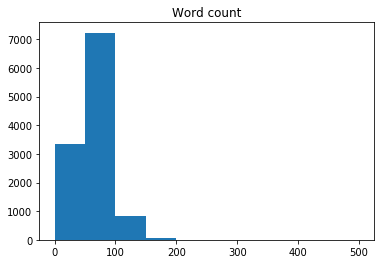

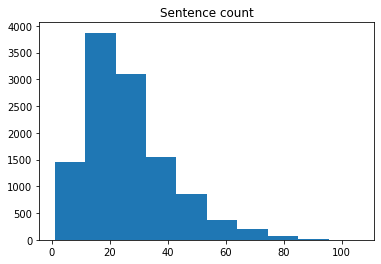

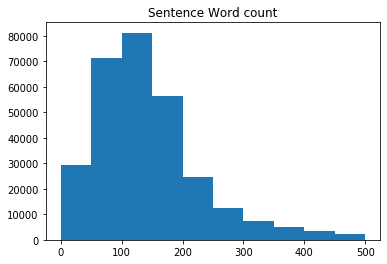

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.title("Word count")
plt.hist(n_highlights_words, range=(0,500))
plt.show()
plt.title("Sentence count")
plt.hist(n_article_sent)
plt.show()
plt.title("Sentence Word count")
plt.hist(n_article_sent_words, range=(0,500))
plt.show()

## Params Dataset

# Model 
1. Use the flair Embedding to get the Context Matrix and then user your one decoder
2. then try to get the vocab input for addidtional information and better results

![Model](img/TextSummaryModel.png)

## Attention

$$ Attention(Q,K,V) = softmax(\frac{Q*K^{T}}{\sqrt{d_k}} ) * V  $$
 
Query $Q$ and Key $K$ represent the input, the dot product of them shows which key words the query word should focus on. The softmax gives them probabilistic values which define which words from the Value Matrix $V$ are relevant.
   

## Compute pytorch Dataset with flair
- for faster training, we will clean the data, compute the Albert-Base Embedding of all articles and save it to Files, so that we don't have to do it while training

In [7]:
albert = BertEmbeddings(bert_model_or_path="albert-base-v2")

albert_embedding = DocumentPoolEmbeddings([albert])

In [8]:
sent = Sentence("Berlin and Munich are nice cities .")
albert_embedding.embed(sent)

embedd_result = sent.get_embedding()
print(embedd_result.shape)
print(embedd_result)

torch.Size([3072])
tensor([-0.6863, -0.5820,  1.0685,  ...,  0.7118,  0.6721,  0.5402],
       device='cuda:0', grad_fn=<CatBackward>)


In [13]:
test_df.articles[0]

"ever noticed how plane seats appear to be getting smaller and smaller? with increasing numbers of people taking to the skies, some experts are questioning if having such packed out planes is putting passengers at risk. they say that the shrinking space on aeroplanes is not only uncomfortable - its putting our health and safety in danger. more than squabbling over the arm rest, shrinking space on planes putting our health and safety in danger? this week, a u.s consumer advisory group set up by the department of transportation said at a public hearing that while the government is happy to set standards for animals flying on planes, it doesn't stipulate a minimum amount of space for humans. 'in a world where animals have more rights to space and food than humans,' said charlie leocha, consumer representative on the committee.\xa0'it is time that the dot and faa take a stand for humane treatment of passengers.' but could crowding on planes lead to more serious issues than fighting for spa

#### Error with pandas writing np.array to csv
[-2.46214211e-01 -3.16317886e-01  8.51760387e-01 ... -3.47209573e-02
   4.56400543e-01 -9.96351242e-04]
  

- We need to disable the numpy option to cut (summarize) the array. We have a (30,3072) array so we just set the threshold higher than that.

In [14]:
np.set_printoptions(threshold=np.inf)

In [15]:
def embed_sentences(sentences):
    arr_embedding = np.zeros((MAX_SENT_N, 3072))
    for i, sentence in enumerate(sentences):
        if len(sentence) > 0 and i < MAX_SENT_N:
            sent = Sentence(sentence[:MAX_WORD_SENT_N])

            albert_embedding.embed(sent)
            x = sent.get_embedding()
            x = x.to('cpu').detach().numpy()
            arr_embedding[i] = x
    
    return arr_embedding

embed_sentences(split_in_sentences(test_df.articles[0]))[0]

array([-2.46214211e-01, -3.16317886e-01,  8.51760387e-01, -2.93171015e-02,
        5.78818977e-01, -3.80471021e-01,  3.12003791e-02, -3.77522111e-01,
        5.39302051e-01,  8.84509861e-01,  3.32353301e-02, -2.74741799e-01,
       -2.54008502e-01, -2.98147742e-03,  3.23375106e-01, -3.57275933e-01,
        1.04109079e-01, -5.15647531e-01,  3.60354334e-01, -5.80869377e-01,
       -4.20482069e-01,  3.63524258e-01, -1.82922602e-01,  4.86208171e-01,
        2.26162538e-01, -7.90269852e-01, -1.87414542e-01, -2.91367203e-01,
        1.84498042e-01,  2.94901311e-01, -6.27313077e-01,  9.57504287e-03,
       -1.10631859e+00,  2.27907583e-01, -9.94201851e+00, -3.00383233e-02,
        1.94614053e-01,  9.88482773e-01,  7.98843443e-01, -3.48279506e-01,
       -4.10172567e-02, -3.61480832e-01,  5.89700818e-01, -3.61467212e-01,
       -1.65746331e-01, -3.50877374e-01, -1.75636828e-01, -5.61444350e-02,
        6.23916447e-01,  5.15762329e-01,  4.36273694e-01,  3.59326214e-01,
        9.76894200e-02,  

In [17]:
def transform_to_numpy(ds):
    len_ds = len(ds)
    article_np = np.zeros((len_ds, 30, 3072))
    
    highlight_list = []
    n_highlight_list = []
    
    for i, (article, highlight) in ds.iterrows():
        article_sent = split_in_sentences(article)
        article_np[i] = embed_sentences(article_sent)
        
        highlight_ids = np.array(get_ids_from_vocab(highlight))[:MAX_WORD_N]
                                 
        highlight_list.append(highlight_ids)
        n_highlight_list.append(highlight_ids.shape[0]) 
        
    return article_np, n_highlight_list, highlight_list

# t_df = test_df[:100]
# article_np, n_highlights, highlights = transform_to_numpy(t_df)

In [19]:
def compute_and_save_df(df, name):
    article_np, n_highlights, highlights = transform_to_numpy(df)

    path = "data/%s" % (name)
    if not os.path.exists(path):
        os.mkdir(path)
    np.save(str(path + "/article" + ".npy"), article_np)
    np.save(str(path + "/n_highlights" + ".npy"), n_highlights)
    np.save(str(path + "/highlights" + ".npy"), highlights)

# compute_and_save_df(t_df, "test")

In [22]:
compute_and_save_df(test_df, "test")

In [23]:
compute_and_save_df(val_df, "val")

### Define Pytorch Dataset and Dataloader

In [8]:
def load_np_files(name):
    path = "data/%s" % (name)
    
    article_np = np.load(str(path + "/article" + ".npy"), allow_pickle=True)
    n_highlights = np.load(str(path + "/n_highlights" + ".npy"), allow_pickle=True)
    highlights = np.load(str(path + "/highlights" + ".npy"), allow_pickle=True)
    
    return article_np, n_highlights, highlights
# x,y,z = load_np_files("test")
# x.shape

In [21]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, article, n_highlights, highlights,transform=None):
        self.x = self.to_tensor_list(article, dtype=torch.float)
        
        self.y_n = torch.tensor(n_highlights, dtype=torch.long)
        self.y = self.to_tensor_list(highlights, dtype=torch.long, pad=MAX_WORD_N)
        
    def __getitem__(self, index):
        x = self.x[index]
        y_n = self.y_n[index]
        y = self.y[index]
            
        return x, y_n, y
    
    @staticmethod
    def to_tensor_list(x, dtype, pad=None):

        if pad is None:
            tensor_list = [torch.tensor(x_i, dtype=dtype) for x_i in x]
        else:
            tensor_list = [torch.cat((torch.tensor(x_i[:MAX_WORD_N], dtype=dtype), \
                                      torch.zeros(pad - x_i[:MAX_WORD_N].shape[0], dtype=dtype))) for x_i in x]
               
        return tensor_list
    
    def __len__(self):
        return len(self.x)

In [22]:
def load_torch_dataset(name):
    x,y,z = load_np_files(name)
    return MyDataset(x,y,z)

In [23]:
# train_ds = MyDataset(train_np)
test_ds = load_torch_dataset("test")
train_ds = load_torch_dataset("val")

In [24]:
# we have diffrent a dynamix input, which the Dataloader can't put together in a batch
BATCHSIZE = 10
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCHSIZE)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=BATCHSIZE)

## Define Decoder
- https://towardsdatascience.com/how-to-code-the-transformer-in-pytorch-24db27c8f9ec
- https://pytorch.org/tutorials/beginner/transformer_tutorial.html

In [31]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=30000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [187]:
class ContextDecoder(nn.Module):
    def __init__(self, max_sent, d_model, nhead, dim_feedforward, out_dim=150, dropout=0.1):
        super().__init__()
        self.max_sent = max_sent
        transfrom_decode_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward,\
                                                            dropout=dropout, activation='relu')
        
        self.transformer_decoder = nn.TransformerDecoder(transfrom_decode_layer, num_layers=1)
        self.out_put_layer = nn.Linear(3072, out_dim*200)
        
        
    def forward(self, context, mask=None):
        # dims
        bs = context.shape[0]
        dim_context = context.shape[2]
        
        context_memory = torch.zeros(context[:,0,:].shape).to(device).reshape(bs,1,dim_context)
       
        for i in range(self.max_sent):
            context_memory = self.transformer_decoder(context[:,0,:].reshape(bs,1,dim_context), context_memory)
        
        # reshape
        context_memory = context_memory.reshape(bs, dim_context)
        out = self.out_put_layer(context_memory).reshape(-1,150,200)
        return out
    


class TransformerModel(nn.Module):

    def __init__(self, n_vocab, emsize, nhead, nhid, nlayers, max_sent=30, c_d_model=3072, dropout=0.2):
        """
        @param n_vocab: vocab_size
        @param emsize: embedding size
        @param nhead: the number of heads in the multiheadattention models
        @param nhid: the dimension of the feedforward network model in nn.TransformerEncoder
        @param nlayers: the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
        @param dropout: the dropout value
        """
        super(TransformerModel, self).__init__()
        
        from torch.nn import TransformerEncoder, TransformerEncoderLayer
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(emsize, dropout)
        
        encoder_layers = TransformerEncoderLayer(emsize, nhead, nhid, dropout)
        
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(n_vocab, emsize)
        self.emsize = emsize
        self.decoder = nn.Linear(emsize, n_vocab)
        self.context_decoder = ContextDecoder(max_sent, c_d_model, nhead, nhid, dropout=dropout)
        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, context):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.encoder(src) * math.sqrt(self.emsize)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        context_sum = self.context_decoder(context)
        output += context_sum
        output = self.decoder(output)
#         print("output", output.shape)
        return output
    

# Train

In [188]:
n_vocab = 30000

In [189]:
model = TransformerModel(n_vocab=n_vocab, emsize=200, nhead=2, nhid=200,\
                         nlayers=1, max_sent=30, c_d_model=3072, dropout=0.2).to(device)

In [190]:
criterion = nn.CrossEntropyLoss()
lr = 5.0 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

In [191]:
EPOCHS = 1

for i in range(EPOCHS):
    model.train() 
    total_loss = 0.
    start_time = time.time()
    for i, (x, n, y) in enumerate(train_loader):
        x = x.to(device)
        n = n.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        output = model(y, x)
        loss = criterion(output.view(-1, n), y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = 200
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // bptt, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()
        break

src torch.Size([10, 150, 200])
output torch.Size([10, 150, 30000])


TypeError: view(): argument 'size' must be tuple of ints, but found element of type Tensor at pos 2

In [104]:
x = torch.zeros((150)).view((-1))
x.shape

torch.Size([150])

In [176]:
m = nn.Linear(3072, (150*200))
input = torch.randn(10, 3072)
output = m(input).view(-1, 150, 200)
print(output.size())

torch.Size([10, 150, 200])
